# HW 4 - Supervised Learning at Scale.
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the first three homeworks you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning alogorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this week's assignment we'll perform 3 kinds of linear regression: OLS, Ridge and Lasso. As in previous assignments you will implement the core calculations using Spark RDDs... though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:  
* ... __define__ the loss functions for OLS, Ridge and Lasso regression.
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [Spark 2.2 Documentation - RDD programming guide](https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__ 

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Opimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6 you discussed some of the theory behnid why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) short response:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) short response:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) short response:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) BONUS:__ In the context of OLS, what do we mean by a 'closed form solution' and why is it not scalable?

### Q1 Student Answers:
> __a)__  
> First order condition is that the local minimum or maximum happens where the first order partial derivatives of the loss function with respect to the parameters individually are equal to zero.  
> Second order condition is that if the second order derivatives at the location of the local extremum are positive, then we have a local minimum, and if the second order derivatives at the location of the local extremum are negative, then we have a local maximum. 
>  
> In addition, if we can prove that the second order derivatives are always positive, then we can say the loss function is convex. When we run Gradient Descent using small enough learning rate, we will always converge at the global minimum which is the optimal solution of our parameters that minimizes loss.  
> _Source: Week 6 Live Session Demo Workbook_ 

> __b)__  
> The two spaces can both be used to think about loss in our algorithm optimization; however, they represent loss as a function of different componets. In the context of Gradient Descent, for each update we make, we create a new model. When plotting the models for each update in the problem domain space, we see how far away our data points are from our models. That is, in the problem domain, loss is represented as a function of data. On the other hand, when plotting the models for each update in the model parameter space, we see how far away our current paramter is from the optimal model. The model parameter space helps us think about loss as a function of the parameters.  
>  
> In practice, we can't find the optimal model by looking at the error surface because we wouldn't have an error surface until we calculate the error with respect to the entire range of our model paramter space. It is computational infeasible in many cases and not cost effective in general.
>
> _Source: Week 6 Live Session Demo Workbook_  

> __c)__  
> Learning rate represents how big of a step we take for each update. The larger the learning rate, the quicker Gradient Descent algorithm will possibly converge. Also, sometimes a larger learning rate helps the algorithm to get out of a local minimum and converge at a global minimum. However, when learning rate is set to be too large, there is a risk of overshooting and causing the algorithm to fail at converging.  
>  
> Therefore, the tradeoff is mainly between the time to take for the algorithm to converge and the certainty that a convergence will happen. Plus, sometimes having a large enough learning rate might help the alogrithm to converge at global maximum.

> __d)__ When we use OLS to formulate the loss function for linear regression, our loss function is: $f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i]^2$ since this function is convex, we know that where first order condition is met is the local minimum. That is where: $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i] \cdot \mathbf{x}'_i = 0$.  
> The closed form solution refers to solving directly for $\boldsymbol{\theta}$. This closed form solution will require finding the inverse matrix of the product of our entire training set with its own transpose. Inverting a matrices is very computationally involved and not scalable. Therefore, the closed form solution is not scalable.  
> _Source: Week 6 Live Session Demo Workbook_  

# About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [5]:
# make a data folder & download red & white wine files
# !mkdir data
# !wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
# !wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [6]:
# extract header fields - RUN THIS CELL AS IS
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [7]:
# load the raw data into an RDD - RUN THIS CELL AS IS
redsRDD = sc.textFile('data/reds.csv')\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
whitesRDD = sc.textFile('data/whites.csv')\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine

In [8]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [9]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [10]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

# Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then a series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

### Q2 Tasks:
* __a) short response:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Comment on the distributions you observe (eg. _Which features appear normaly distributed, which don't? Which features vary most/least?_) How is the varaible `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __b) short response:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a positive linear relationship with `quality`? Which if any appear to have a negative linear relationship with `quality`?


* __c) short response:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (postively or negatively) associated with each other? What implications would that have for our feature selection?

### Q2 Student Answers:
> __a)__  
> `pH` and `density` seem to be distributed normally. `Fixed acidity` seem to be mostly normally distributed but having a longer tail to the right. The rest of the numeric features are right-skewed.   
> 
> `Alcohol` and `total sulfur dioxide` seem to have greater variability than other features. Whereas, `chlorides` and `residual sugar` seem to have less variability.  
> Unlike the rest of the numeric features, the variable `color` is a categorial variable which takes on value either, 1(red wine) or 0(white wine). Because of the nature of the variable, instead of interpreting the coefficient as the increase in the outcome variable when the variable increase by one unit, it is interpreted as the increase in the outcome variable when a wine is red.

> __b)__  
> On average, `free sulfur dioxide` seems to have a positive linear relationship with quality respectively.  
> On average, `fixed acidity` and `volatile acidity` seem to have a negative linear relationship with quality respectively.

> __c)__  
> `volatile acidity - color`, `total sulfer dioxide - free sulfur dioxide`, `density - residual sugar`, `total sulfur dioxide - color`, `alcohol and density` are strongly correlated pairs of features.
> Including strongly correlated pairs of features in a linear regression model might lower the statisitcal significance of coefficient estimates of those variables, and make the features seem less important than they actually are. If we didn't do any feature selection and just remove all the features that have low statistical significance, our model might perform poorly. Therefore, in order to correctly measure the importance of strongly correlated features, we may need to either drop one of the highly correlated features from a pair, combine a pair to form one new feature, or use regularization so the redundant information carried by the pair will not undermine our model. 


In [11]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

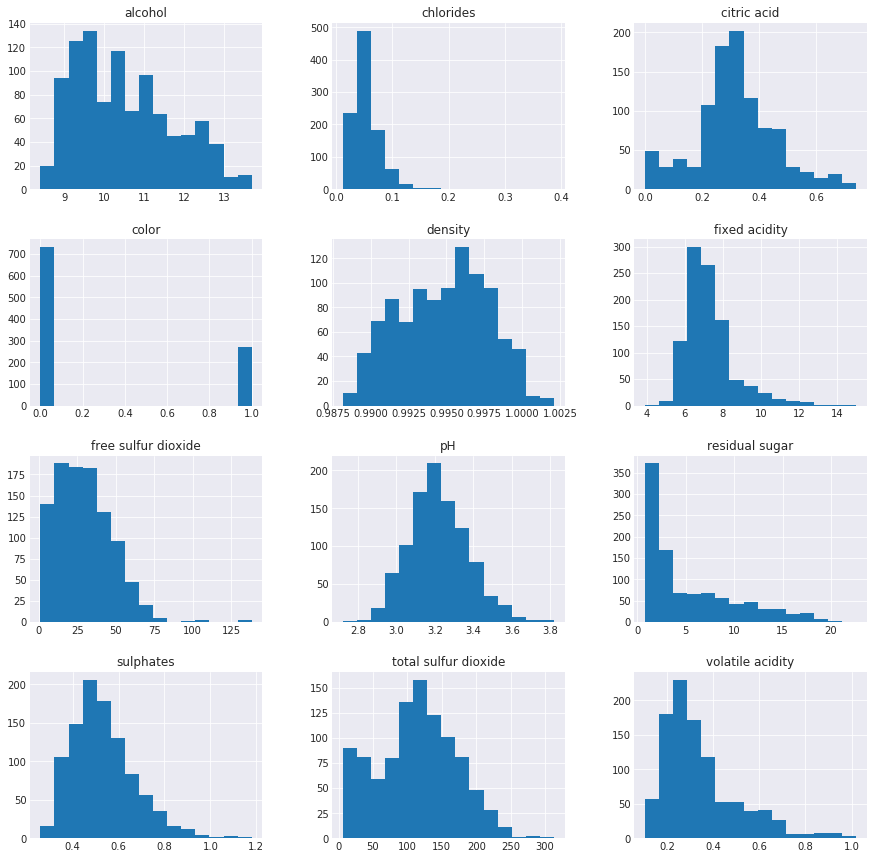

In [12]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

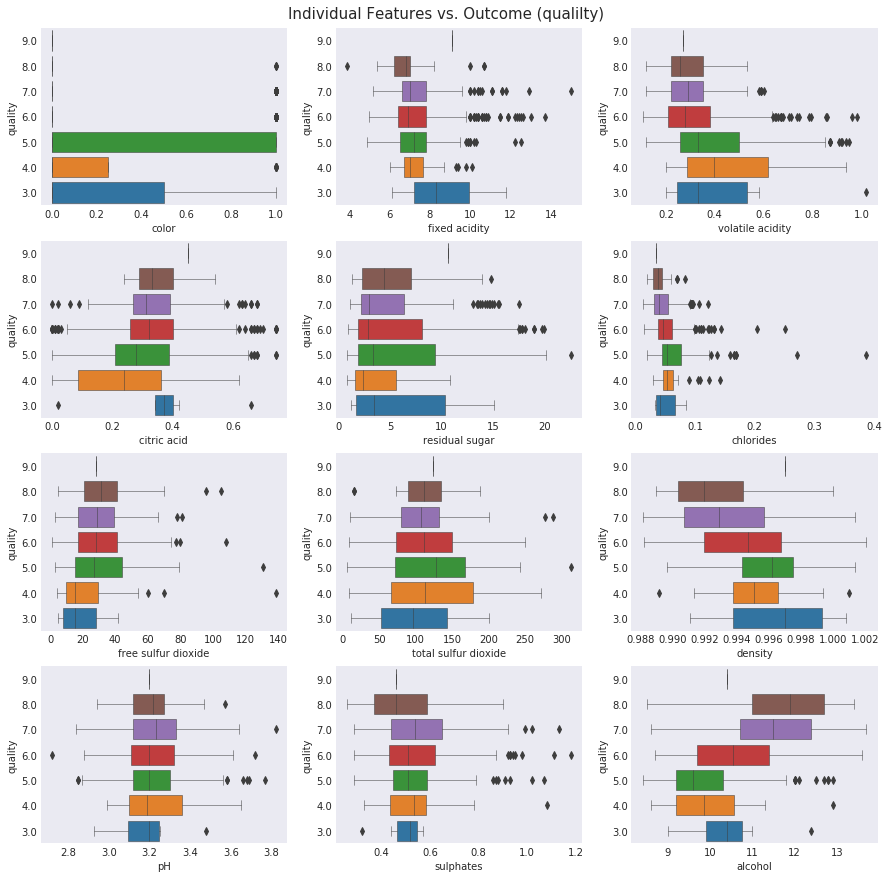

In [13]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

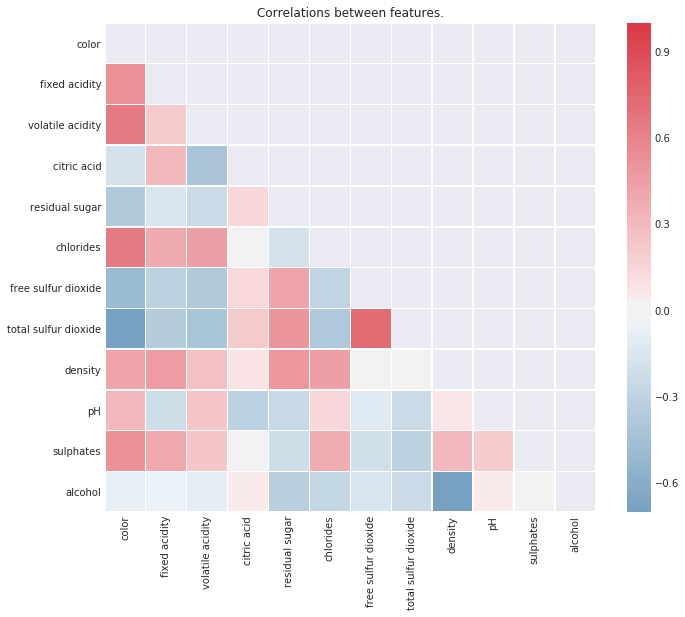

In [14]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. 

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb. It is useful as a simple baseline to compare with other (real) regressors. Examples of regression baselines include:
* "mean": always predicts the mean of the training set
* "median": always predicts the median of the training set
* "quantile": always predicts a specified quantile of the training set,provided with the quantile parameter.
* "constant": always predicts a constant value that is provided by the user.

In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

#### Baseline example illustrated:

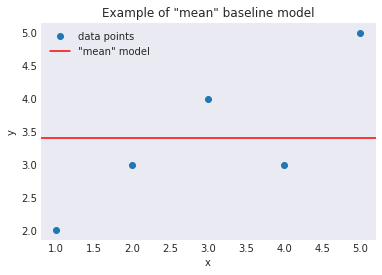

In [15]:
# points from our mini example from the demo 6 notebook  (RUN THIS CELL AS IS)
points = np.array([[1,2],[3,4],[5,5],[4,3],[2,3]])
x = points[:,0]
y = points[:,1]

plt.figure()
plt.plot(x, y,'o', label='data points')
plt.axhline(np.mean(y),c='r', label='"mean" model')
plt.title('Example of "mean" baseline model')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show()

### Q3 Tasks:
* __a) code:__ Fill in the code below to compute the mean and variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]


* __b) short response:__ Write the formula for the OLS loss function and explain how to interpret it graphically.


* __c) short response:__ In the context of linear models & vector computations what does it mean to 'augment' a data point and why do we do this?


* __d) code + short response:__ Fill in the missing code to complete the`OLSLoss` function. Is computing the loss "embarassingly parallel'? Explain. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __e) code + short response:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model. Compare your results to the result you got in `part a` and explain what you see.

### Q3 Student Answers:
> __b)__   
> The loss function is: $f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i]^2$  
> The graphical interpretation of the OLS loss is distance:  
>> $\boldsymbol{\theta}^T\cdot\mathbf{x}'_i$ is the predicted value by the model for a given input data point, $\mathbf{x}_i$  
>> Therefore, $[\boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i]^2$ is the squared distance from the true response to the predicted value for a given input data point, $\mathbf{x}_i$  
>> The loss, $\frac{1}{n}\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i]^2$ is the average squared distance from the true responses to the predicted values for all the data points used in training.  
>
> _LaTeX code source: Week 6 Live Session Demo Workbook_  

> __c)__  
> It means to add a term of value, 1 to the matrix for a data point. It makes the matrix expression of the loss function cleaner and easier to write because we can include the intercept into the parameter matrix and the prediction by the model using a data point is just the dot product of the two.

> __d)__ Yes. The loss for each data point can be calculated separately without any communication between the tasks. After all the individual losses are calculated, we just sum it up and divide by the number of data points as the reducing step.

> __e)__ The loss we get from the calculation is identical to the variance of outcome variable. Since our prediction for each data point is always the average of the outcome variable and we get the difference between that and each response then use it in the loss calculate; therefore, we get the identical results.
> That is: When  
> $\hat{y_i} = \boldsymbol{\theta}^T\cdot\mathbf{x}'_i = \bar{y}, $    
> $f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i]^2 = \frac{1}{n}\sum_{i=1}^{n}[\bar{y} - y_i]^2 = \frac{1}{n}\sum_{i=1}^{n}[y_i - \bar{y}]^2 = Var(y)$  
> _LaTeX code source: Week 6 Live Session Demo Workbook_ 

In [16]:
# part a - mean and variance of the outcome variable 
meanQuality = trainRDDCached.map(lambda x: x[1]).mean() # FILL IN YOUR CODE HERE
varQuality = trainRDDCached.map(lambda x: (x[1]-meanQuality)**2).mean() # FILL IN YOUR CODE HERE
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 5.811040339702759
Variance: 0.7600865648656636


In [17]:
# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    loss = augmentedData.map(lambda x: (W.dot(x[0].T)-x[1])**2).mean()
    ################## (END) YOUR CODE ##################
    return loss

In [18]:
# part e - define your baseline model here
BASELINE = np.append([1.0], np.zeros(len(FIELDS)-1)) * meanQuality

In [19]:
# part e - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")

Baseline model loss: 0.7600865648656636


# Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a) short response:__ Jimi describes the main part of the gradient calculation for OLS Regression using a short mantra: _'the mean of the data weighted by the errors'_. . Write the formula for the gradient and explain how it reflects this phrase. 

* __b) short response:__ Looking at the formula you wrote in `part a`, what parts of this calculation can be parallelized and what has to happen after reducing?


* __c) code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  


* __d) short response:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?


* __e) code + short response:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. Use these results to explain what the problem was in 'd'.
    * __`TIP:`__ _You may find [this brief illustration](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) from Andrew Ng's Coursera helpful._


### Q4 Student Answers:
> __a)__  $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i] \cdot \mathbf{x}'_i$  
> Looking at the formula above, we can see that $\boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i$ is the error of the ith prediction made by the model. We sum over the product of the ith error times the ith data point, $\mathbf{x}'_i$. Then we take the average by dividing over the number of data points.  
> Though there's a constant multiplier of two, but the above process is basically calculating the weighted mean by the errors of the data  
> _LaTeX code source: Week 6 Live Session Demo Workbook_ 

> __b)__ $[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i] \cdot \mathbf{x}'_i$ of the calculation can be parallelized over data points since it only involves individual data points. However, the summing and averaging will need to happen in the reducing phase.

> __c)__ _complete the coding portions of this question before answering d & e_ 

> __d)__ Gradient Descent diverged. As we ran more steps, the loss became bigger and seemed to grow without bound.

> __e)__ Since the data wasn't normalized, our features take on very different ranges. When we calculate gradients, since all features have the same learning rate, paramters of features having large value range could be updated with much greater amount in each iteration, so large that it might cause the algorithm to overshoot and diverge.  

In [20]:
# part b - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    grad = augmentedData.map(lambda x: (W.dot(x[0].T)-x[1])*x[0]).mean() * 2
    new_model = W - learningRate * grad
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [21]:
%%time
# part c - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)

nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
    loss = OLSLoss(trainRDDCached, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 3255.0397706648123
Model: [5.811, -0.009, -0.017, -0.007, 0.002, -0.035, -0.001, 0.167, -0.489, -0.0, 0.0, 0.001, 0.094]
----------
STEP: 2
Loss: 41538896320.900734
Model: [15.998, 0.946, 71.311, 3.109, 3.394, 67.104, 0.517, 372.213, 1469.681, 10.133, 32.587, 5.197, 105.407]
----------
STEP: 3
Loss: 5.321516254246974e+17
Model: [-36732.224, -3790.819, -257459.013, -11294.195, -12193.785, -240557.886, -1880.28, -1359608.579, -5252902.327, -36544.479, -117571.505, -18781.008, -379946.295]
----------
STEP: 4
Loss: 6.817355374095457e+24
Model: [131498780.95, 13574790.866, 921540888.277, 40426173.604, 43645471.549, 861027822.897, 6730358.366, 4867148463.848, 18801163135.814, 130805962.538, 420832007.136, 67225003.981, 1359973545.811]
----------
STEP: 5
Loss: 8.733663880159665e+31
Model: [-470665198626.593, -48587550191.15, -3298412689019.937, -144694834630.261, -156217444459.899, -3081821742976.596, -24089547803.278, -17420693064

In [22]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: ((x[0]-featureMeans)/featureStdev, x[1]))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [23]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [24]:
%%time
# part e - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 0.6555276691703891
Model: [5.811, -0.02, -0.014, -0.045, 0.014, -0.007, -0.035, 0.009, -0.009, -0.054, 0.003, 0.008, 0.078]
----------
STEP: 2
Loss: 0.615059239044261
Model: [5.811, -0.022, -0.014, -0.071, 0.023, -0.006, -0.05, 0.014, -0.021, -0.079, 0.007, 0.024, 0.131]
----------
STEP: 3
Loss: 0.5935522582531458
Model: [5.811, -0.018, -0.01, -0.09, 0.03, 0.002, -0.057, 0.02, -0.032, -0.09, 0.011, 0.04, 0.167]
----------
STEP: 4
Loss: 0.5798853360580277
Model: [5.811, -0.014, -0.006, -0.105, 0.034, 0.012, -0.061, 0.026, -0.04, -0.094, 0.013, 0.054, 0.195]
----------
STEP: 5
Loss: 0.5703196233260643
Model: [5.811, -0.009, -0.003, -0.117, 0.036, 0.024, -0.063, 0.032, -0.047, -0.096, 0.016, 0.066, 0.217]
CPU times: user 109 ms, sys: 32.8 ms, total: 142 ms
Wall time: 1.87 s


# Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question you'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split for the purposes of this question dividing the existing training set into two smaller RDDs.

### Q5 Tasks:
* __a) short response:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 


* __b) code:__ Since we're going to be running Gradient Descent a number of times let's package it into a function for convenience. Fill in the missing code in `GradientDescent()`, note that the missing code is going to look a lot like the provided code blocks in Q5 -- feel free to use those as a starting point.


* __c) short response:__ Use the provided code to split the normalized data into a test and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.


* __d) short response:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit` allows us to pseudo randomize our test/train split in a way that is replicable. Re-run the code for part 'c but this time in the line where we perform the `normedRDD.randomSplit` change the seed to _`seed = 5`_. What changes in the plot? Repeat for _`seed = 4`_. How does this change your interpret the results you saw in 'c'. What is the more likely explanation?

### Q5 Student Answers:
> __a)__ Because it only assesses how well the model fits the training data. It doesn't tell me how well it will perform on data points it has never seen before.

> __c)__ Test loss decreases as the training loss decreases; however, the test loss is always higher than the training loss.  
> The test error decreases with the trainining error becasue as we run more iterations, the model is trained more, so it does a better job at predicting the test examples. However, the model could never predict the examples it's never seen as good as the examples it's trained on. 

> __d)__  
> When the seed was changed to 5, the graph change in a way that the test loss was initially lower than the training loss; however, as more iterations are run, they both decrease and the training loss eventually became smaller than the test loss.  
> Initially, I was very suprised to see the graph of seed=4, where the training loss is always higher than the test loss though they still have the same trend. The two losses having the same trend is consistent across all graphs, and that is just the natural result of our training when the model is not overfitting the training data.  
> However, I think I would correct my explanation in part c) about the how training loss is going to always be lower than test loss. I realized now that it is not gauranteed that the training loss is always going to be smaller than the test loss when data is split into the two sets randomly. Sometimes, we might just have a test set that has examples a lot closer to the trained model than the training examples by chance.


In [25]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        normedTrainRDD = normalize(trainRDD)
        normedTestRDD = normalize(testRDD)
        model = GDUpdate(normedTrainRDD, model)
        training_loss = OLSLoss(normedTrainRDD, model) 
        test_loss = OLSLoss(normedTestRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [26]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [27]:
%%time
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 4)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 33.293325424194336 seconds
CPU times: user 3.05 s, sys: 436 ms, total: 3.48 s
Wall time: 33.3 s


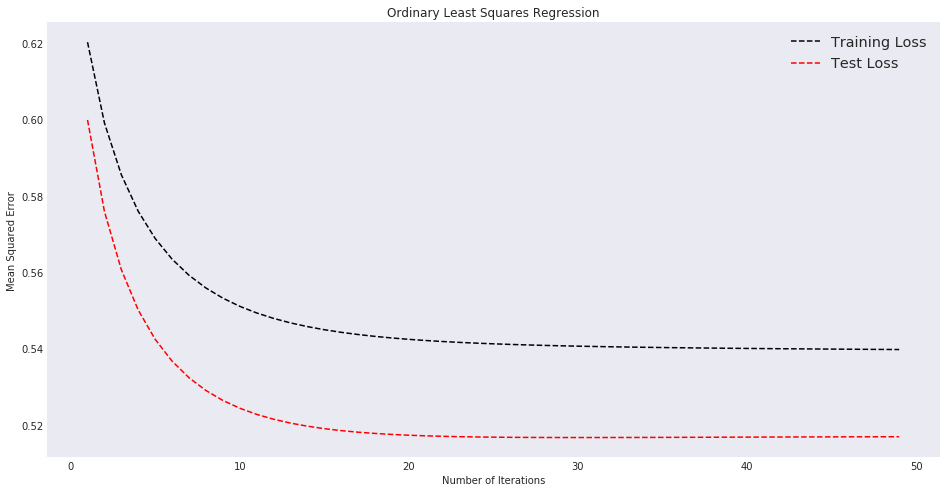

In [28]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [29]:
# save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

# Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place no shuffle needed for the aggregation. 

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), sometimes called rotation estimation, or out-of-sample testing, is a model validation technique for assessing how well the model will generalize to an independent data set. The goal of cross-validation is to test the model's ability to predict new data. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

#### From ISLR Chapter 5.1 - Cross Validation
<img src="CV-ISLRp181.png">


### Q6 Tasks:
* __a) short response:__ A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data? [__`HINT:`__ _it will depend on factors that you should be able to name._]


* __b) short response:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. For each record in the original dataset, how many tuples does `kResiduals()` emit? What are the keys of these newly emitted records? How will these keys help us compute cross validated loss?


* __c) code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross validated error for a given set of data splits and their corresponding models. [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __d) code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __e) short response:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph? 

### Q6 Student Answers:
> __a)__ If we are training the models in sequence, and assuming we are making $n$ updates to our parameters for each model. We will have make $4n + 1$ passes over our entire datasets. 
> $4n$ times is a result of the training 5 different modols becasue each model has $\frac{4}{5}$ of the data to used in training and we need to go through them n times. Finally, we have 5 models to train, so the total times to pass the data to train the models is: $\frac{4}{5}\cdot n\cdot 5 = 4n$  
One more pass is the sum of passes we need to make to evaluate the performance of each model on the portion of the data it wasn't trained on. Therefore, it's a total of $4n+1$ times where n = the number of updates to train each model.

> __b)__
> 5 records  
> The keys are composite keys. They have two parts: one about which model the loss is associated with and the other is about whether it is a training loss or test loss.
> They are aggregated by key in `CVLoss` function, and we take the mean to get the training and testing loss of a given model.

> __e)__ The cross validation shows the trend that was expected. The training error is higher than the test error and they have the same trend, that is as we perform more iterations of gradient descent, both errors were decreasing. I also tried different splits by changing the random seeds, and the two features (trending down and the training loss is lower) of the graph remain the same. This is also a proof that since we are averaging the losses from five different models, the result of graph is more resilient to random variation in the input was split into training set and validation set. 

In [30]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the training set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [31]:
# part c - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    ################ YOUR CODE HERE #################        
    loss = partialLossRDD.mapValues(lambda x: (x,1.0)).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).mapValues(lambda x: x[0]/x[1]).collect()
    
    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [32]:
# part d - helper function RUN THIS CELL AS IS
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [33]:
# part d - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        new_models.append(W-learningRate*grad)
        ############# (END) YOUR CODE ###########
    return new_models

In [34]:
# part e - RUN THIS CELL AS IS
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist

In [35]:
# part d -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, nSteps = 50, verbose=False)


... trained 50 iterations in 106.9909782409668 seconds


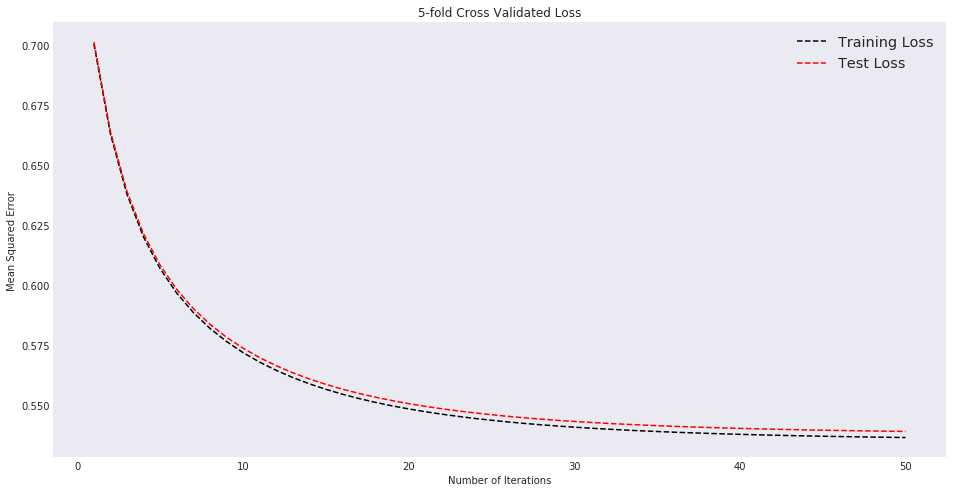

In [36]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

# Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are $2^{p}$ potential models that can be built from $p$ features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) short response:__ The regularization term for ridge regression is the square of the $L2$ norm of the weights vector (i.e. the sum of squares of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Ridge Regularization and explain what extra step this will add to our gradient descent algorithm.


* __b) short response:__ The regularization term for lasso regression is the $L1$ norm of the weights vector (i.e. the sum of the absolute values of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Lasso Regularization and explain how the gradient descent update in Lasso will be different than it was in Ridge.


* __c) code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using $L2$ regularization if the parameter `regType` is set to `ridge`, $L1$ regularization if set to `lasso` and unregularized OLS otherwise.


* __d) code + short response:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expectation?

### Q7 Student Answers:
> __a)__  
> Loss: $f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i]^2 + \lambda||\boldsymbol\theta'||_2^2$, where $\boldsymbol\theta'$ is $\boldsymbol\theta$ without the bias parameter   
> Gradient: $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i] \cdot \mathbf{x}'_i + 2\lambda\boldsymbol\theta'$, where $\boldsymbol\theta'$ is $\boldsymbol\theta$ without the bias parameter  
> The extra step we will need to add to the gradient descent algorithm is to add the additional part of the gradient formula above, $2\lambda\boldsymbol\theta'$ to the calculation for the gradient for each update.

> __b)__   
> Loss: $f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i]^2 + \lambda||\boldsymbol\theta'||_1$, where $\boldsymbol\theta'$ is $\boldsymbol\theta$ without the bias parameter     
> Gradient: $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}[ \boldsymbol{\theta}^T\cdot\mathbf{x}'_i - y_i] \cdot \mathbf{x}'_i + \lambda \cdot sign(\boldsymbol\theta'), where\ sign(\boldsymbol\theta') = [\alpha_1, \alpha_2,\dots, \alpha_{j}],\ and\ \alpha_j =
\begin{cases}
    1,\ if\ \theta_j\ >\ 0\\
    -1,\ if\ \theta_j\ <\ 0\\
    0,\ if\ \theta_j\ =\ 0
\end{cases}
$  
> Instead of adding $2\lambda\boldsymbol\theta'$ to calculate the gradient, we add the product of the ragularization parameter and vector of a series of 1, 0 and -1 (depending on the signs of the current parameters) to the gradient. 

> __d)__  
> I think the result met my expectations overall when compared to the simple OLS model in Q5 with teh same random seed. The train losses of the regularized models match my expectations in such way that the regularized models both had higher errors compared to the unregularized model. 
> As for the test errors, ridge performed slightly better than simple OLS which outperforms lasso a bit.  
> However, since all the errors are only calculated based on one split, it's hard to say the same pattern can be seen when applying the models on unseen data.

In [37]:
# part c - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################
    OLSGrad = augmentedData.map(lambda x: (np.sum(x[0]*W)-x[1])*x[0]).reduce(lambda x,y: x+y)/augmentedData.count() * 2
    
    if regType == 'lasso':
        grad = OLSGrad + regParam * np.append([0.0], np.sign(W)[1:])
    elif regType == 'ridge':
        grad = OLSGrad + 2 * regParam * np.append([0.0], W[1:])
    else:
        grad = OLSGrad
    
    new_model = W - learningRate * grad
    
    
    ################## (END) YOUR CODE ####################
    return new_model

In [38]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        OLSLoss(trainRDD, model)
        
        # keep track of test/train loss for plotting
        
        training_loss = OLSLoss(trainRDD, model)
        test_loss = OLSLoss(testRDD, model)
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [39]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05)
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 23.49849247932434 seconds


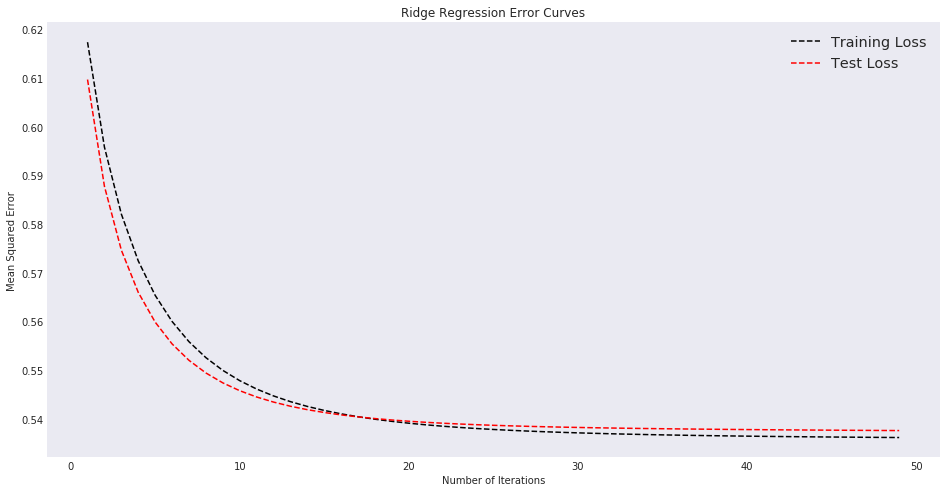

In [40]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
np.savetxt(PWD + '/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [41]:
# run 50 iterations of lasso (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 23.474105834960938 seconds


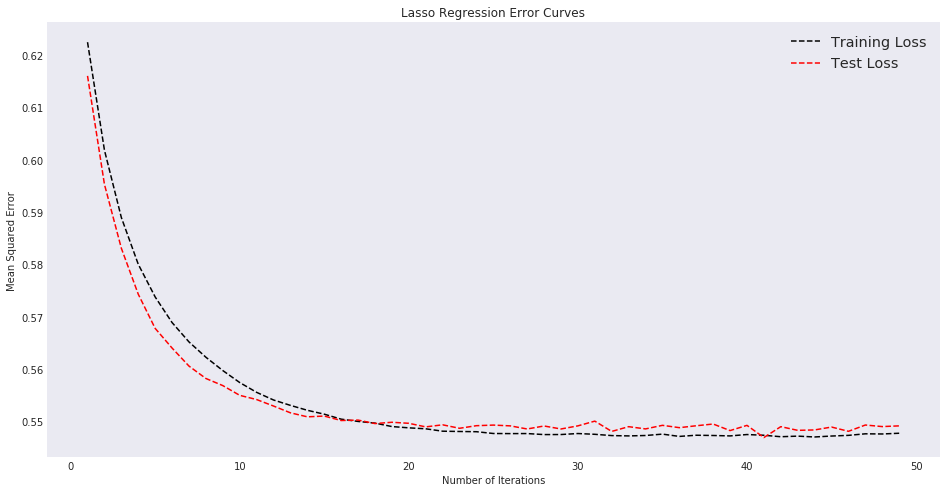

In [42]:
# part d - save and display lasso results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Question 8: Results

In this final question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) code:__ Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method. Then compute the mean squared error on the held out dataset for each of the three models. [__`TIP:`__ _the held out data is in it's raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) short response:__ Which model performed best? Discuss how you interpret these results and what you would want to try next.


* __c) short response:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]


* __d) short response:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process. Please be sure to discuss all three in your response.

### Q8 Student Answers:
> __b)__
> Surprisingly, the best performing model is OLS model.
> Though not by a lot, it seems that lasso regression has the worst performance on our held-out set. This probably means that lowering some of the coefficient all the way to zero doesn't work well with our data. Maybe though some of our features are strongly correlated, they still contain some useful distinct information for prediction.  
> However, since the ridge regression's score is extremely close to the score of the OLS model, and the regularization parameter, 0.05 were just given to us. It might be useful to explore if we can fine tune the regularization parameter with cross-validation to achieve a higher performance in ridge model.

> __c)__ It seems that our models are not very good at predicting more extreme scores. It seems to be under-predicting the scores for highly-scored wines and over-predicting the scores for the lowly-scored wines.

> __d)__  
> __OLS model__: The OLS model adjusts the coefficients with most of the starting at extremely close to zero. OLS increases and decreases them in a way that will minimize the training loss. It's worth noting that some coeficients were first increased and later decreased (or first decreased and later increased). I think this might correspond to the zigzagging of the graph we saw in the live session (though the zigzagging of the graph is an aggregated result of all the coefficient).  
> __Ridge model__: The graph of ridge model looks very similar to that of the OLS model. However, when compared with the OLS model, the ridge model seems to be adjusting the coeffients at a slower rate. The coefficients were also smaller in magnitude at the end of the 50 steps.  
> __Lasso model__: Lasso regression has the most distinct graph in the three of models. Though the coefficients seems to diverge a bit in the first five updates, soon many of them were pushed very close to zero. Lasso also seems to increase the absolute value the coefficients having the greatest influence while lowering the significance of other coefficients.


In [43]:
# part a - load the models from file (RUN THIS CELL AS IS)
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
ridge_models = np.loadtxt(PWD + '/data/ridge_models.csv', dtype=float, delimiter=',')
lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [44]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
############### YOUR CODE HERE #################
trainFeatureMeans = trainRDDCached.map(lambda x: x[0]).mean()
trainFeatureStdev = np.sqrt(trainRDDCached.map(lambda x: x[0]).variance())

validationRDD = heldOutRDD.map(parse).map(lambda x: ((x[0]-trainFeatureMeans)/trainFeatureStdev, x[1]))

olsMSE = OLSLoss(validationRDD, best_ols)
ridgeMSE = OLSLoss(validationRDD, best_ridge)
lassoMSE = OLSLoss(validationRDD, best_lasso)


############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5523530832259615
Ridge Mean Squared Error: 0.5547695952730081
Lasso Mean Squared Error: 0.5624143772925653


In [45]:
# part c - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [46]:
# part c - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(validationRDD, best_ols))
ridge_resid = np.array(get_residuals(validationRDD, best_ridge))
lasso_resid = np.array(get_residuals(validationRDD, best_lasso))

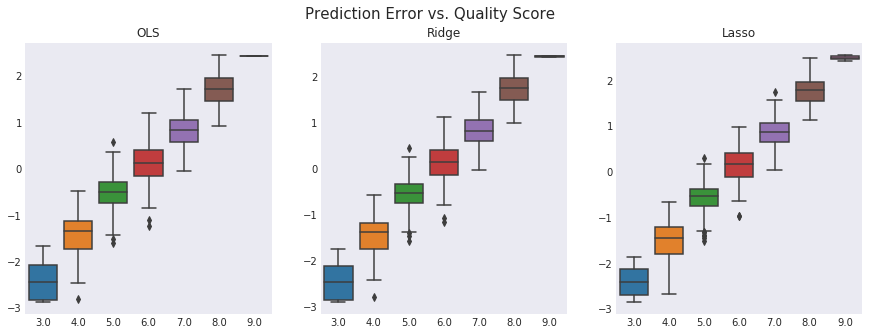

In [47]:
# part c - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x, y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
plt.show()

In [48]:
# part d - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show

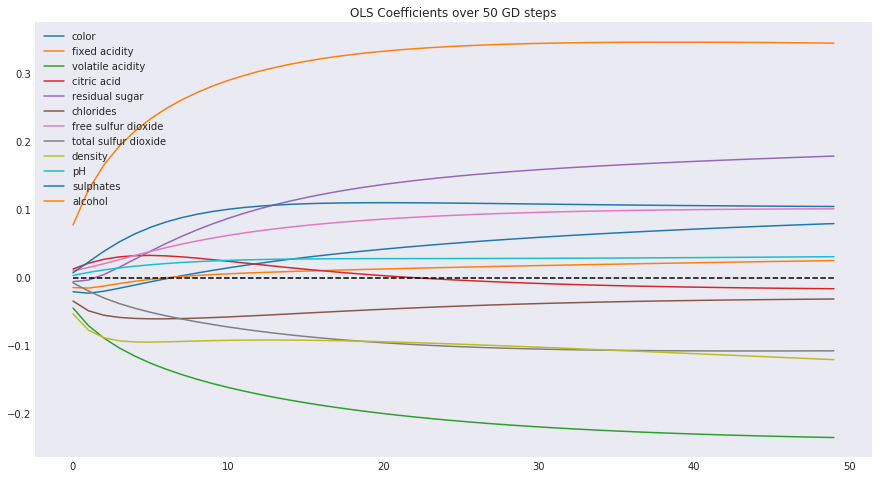

In [49]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

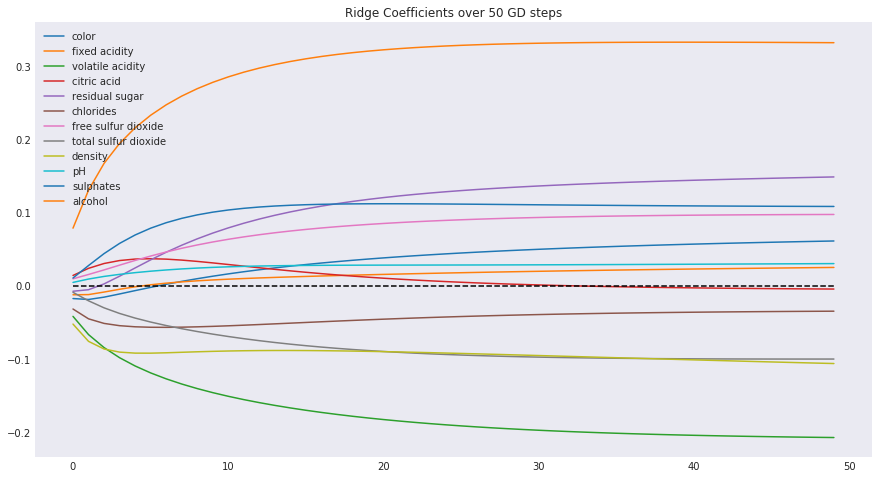

In [50]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

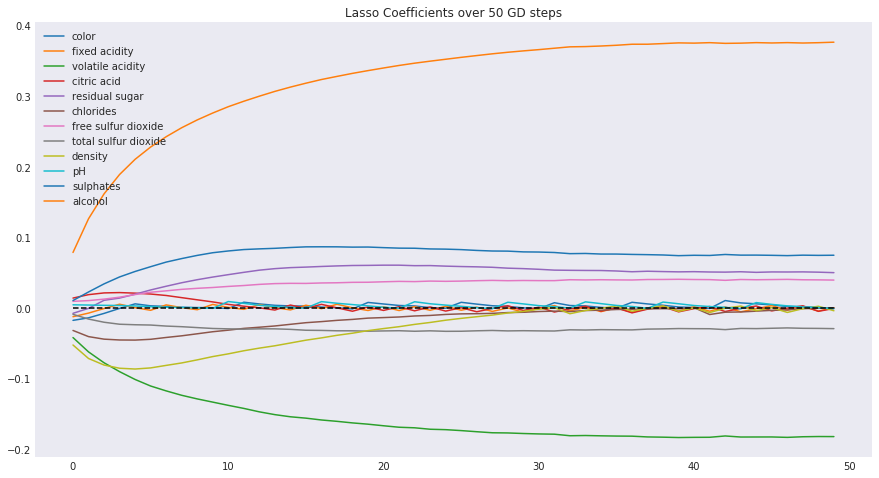

In [51]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations, you have completed HW4! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLScgIz4laP2JHChStLZx8MO0jGvrGyrOyQBnj7M4_4vcVXkB7g/viewform?usp=sf_link

*If you liked this assignment, checkout some additional EDA here: 
https://medium.com/swlh/effective-visualization-of-multi-dimensional-data-a-hands-on-approach-b48f36a56ee8*